# Part Two:  Exploration of Canadian Temperature 
## Visualization of Canadian Temperature Data
This is the first part in the series of analysing temperature in Canadian series. This notebook focus only on exploration of time series also aspects pf the previous file on getting the data are also added. It can be considered as a basic intro but several aspects are covered. This notebook only focus on one city as well. The principle derived here applies to most of the other cities

# Temperature Time Series Visualization

$\mathbf{Time\ series}$ generally refers to data collected over time intervals. Its dependence on time breaks the independence variable assumption used in regression analysis.
This tutorial aims to show some necessary and essential steps taken before carrying a time series of $\textit{forcasting}.  Forecasting refers to making predictions for future trends. It could be in the market, stock price, accidents, the number of patients arriving at a clinic. Most of the concepts presented here equally apply to most time series data. 

In this notebook, however, we will be working exclusively with temperature data. The data is from the NOAA weather station, and we will pick one station in Prince Albert, a city in SK, Canada. The data, as well as its properties, can be found in the [NOAA website](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ "NOAA website"). There are three other stations in Canada, but we will focus on this one which is part of the GCOS Surface Network (GSN). In the next project, we will work with multiple cities.

## 1. Overview of notebook
First, note that this notebook follows a similar approach to that in ref [here](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/?utm_source=blog&utm_medium=stockmarketpredictionarticle).It is also an introductory article on straightforward concepts about time series which will cover aspects like

   - Learn the steps to create a Time Series dataset from the NOAA data
   - Display some features of raw data
   - Prepare or clean the information
   - Visualize temperature variations over a period from 1973 to present
   - Check seasonality and stationarity
   - Additional focus on Dickey-Fuller test

Below are the packages used

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
#used to get data directly from the URL
import urllib.request

#Tools for testing time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf

Changing the size of the default parameter sizes

In [2]:
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
#plt.style.use('fivethirtyeight')
sns.set()

## 2. Getting the data (covered in part 1)
The data as menntion is downloaded from [NOAA link here](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt).
 - Loading and Handling Time Series in Pandas
 - How to Check Stationarity of a Time Series?
 - How to make a Time Series Stationary

In [3]:
#the data of the stations are stored in stations
urllib.request.urlretrieve('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt','stations.txt')

('stations.txt', <email.message.Message at 0x7fdb88cd3f98>)

check the available list of stations that stores the data

In [ ]:
open('stations.txt','r').readlines()[:8]

We will look for Canadian stations with GSN. The code name of stations in Canada starts with 'CA'

In [5]:
Canada_stations = {}
for line in open('stations.txt','r'):
    if (line[:2] == 'CA') and ('GSN' in line):
        fields = line.split()
        
        Canada_stations[fields[0]] = ' '.join(fields[4:])

We can check a few stations

In [6]:
def findstation(s):
    found = {code: name for code,name in Canada_stations.items() if s in name}
    print(found)

In [7]:
findstation('PRINCE')

{'CA004056240': 'SK PRINCE ALBERT A GSN 71869'}


We will be working with Prince Albert data set. There is nothing special about Prince Albert. One can pick any city. The station ID is CA004056240. It is used below to get the data.

In [8]:
urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/gsn/CA004056240.dly', 'CA004056240.dly')

('CA004056240.dly', <http.client.HTTPMessage at 0x7fdb88cfd208>)

We can see that the data doesn't make so much sense at a first glance. To make sense of the data, there is a [readme.txt](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) on the website. Basically, ${-999}$ are NANs. We Below we read a description of a segment of the readme.txt

In [ ]:
urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt', 'readme.txt')
open('readme.txt','r').readlines()[108:128]

## 3. Cleaning/Formatting the data
We definitely need a parser the data. We can note from the data that, each record for example $\textit{open('CA004056240.dly','r').readlines()[0] }$ is a string. The first entry is a combination of the station name and year, month, and the type of measurement (TMIN, TMAX etc). Below is a parser to convert the data into a record array of multiple types.

The function $\text{parsefile}$ helps us read each record from the the station. The parameters specify how the record is read. Let's go through each parameter at a time.

$\textbf{dly_delimiter}$: A quick check [online](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html) provides the info that is is where the read breaks. Lets take a look at the first record which is _'CA004056240194212TMAX -150  C -100  C  -83  C  -94  C -139  C -161  C -194  C -211  C -178  C -217  C -206  C  -72  C   -6  C  -94  C  -61  C  -94  C -189  C -283  C -194  C -161  C -139  C -150  C -156  C -128  C -156  C -183  C  -61  C  -94  C -261  C -206  C -256  C\n'_ First 11 chars, values specifies the station code, next 4 the year, next 2 the month, next 4 the measurement type, then the other values are temperatures and it units C for the next 31 days. After the measurement type, 5 chars (including the space) contains the temperature, and the other 3 (space, C, space) are also read. This is repeated 31 times.

$\textbf{dly_usecols}$: Specify the columns which are used in defining the data. The station code and each of the (_c_) are not used.

$\textbf{dly_dtype}$: The datatypes of each of the columns. We see that the first two the year and month are int while the measurement type is str

$\textbf{dly_names}$: These are names that are used to access each of the columns. The values are specified below

In [10]:
def parsefile(filename):
    '''
    Takes a file and parse it to return a numpy array
    '''
    return np.genfromtxt(filename,
                         delimiter = dly_delimiter,
                         usecols = dly_usecols,
                         dtype = dly_dtype,
                         names = dly_names)

In [11]:
dly_delimiter = [11,4,2,4] + [5,1,1,1] * 31 
dly_usecols = [1,2,3] + [4*i for i in range(1,32)]
dly_dtype = [np.int32,np.int32,(np.str_,4)] + [np.int32] * 31
dly_names = ['year','month','obs'] + [str(day) for day in range(1,31+1)]

Let's parse Prince Albert's temperature data and check these

In [12]:
Prince_Albert = parsefile('CA004056240.dly')
print(Prince_Albert[0])
print('------------------------------Year, month---------------------------------------------------------')
print('Year: ', Prince_Albert[0]['year'], 'Month: ',Prince_Albert[0]['month'])

(1942, 12, 'TMAX', -150, -100, -83, -94, -139, -161, -194, -211, -178, -217, -206, -72, -6, -94, -61, -94, -189, -283, -194, -161, -139, -150, -156, -128, -156, -183, -61, -94, -261, -206, -256)
------------------------------Year, month---------------------------------------------------------
Year:  1942 Month:  12


In [13]:
measurements = set(Prince_Albert['obs']) #Check unique values
measurements

{'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN'}

For now, lets focus on the maximum and minimum temperatures. The data is not in the right format, so lets format itincluding the dates.

In [14]:
def unroll(record):
    '''
    Takes a station temperature data, arrange it as an array of pairs of daily temperature and value
    record: input temperature data
    Pameters:
    -----------
    startdate: the date (yr, m) to start considering
    dates: Hold a date in daily steps
    '''
    startdate = np.datetime64('{}-{:02}'.format(record['year'],record['month']))
    dates = np.arange(startdate, startdate + np.timedelta64(1,'M'), np.timedelta64(1,'D')) #Daily step increment
    
    rows = [(date, record[str(i+1)]/10) for i, date in enumerate(dates)]
    
    return np.array(rows, dtype=[('date','M8[D]'), ('value','d')])

The data is then grouped by day and value

In [15]:
def getobs(filename, obs):
    '''
    Parse a record and each line contain montly record that are unrolled and concated to the data variable
    Parameters:
    ---------------
    filename: specific  record
    obs: is the observation of choice eh TMAX, TMIN etc

    '''
    data = np.concatenate([unroll(row) for row in parsefile(filename) if row[2] == obs])
    
    data['value'][data['value'] == -999.9] = np.nan
    
    return data

In [16]:
Prince_Albert_tmax = getobs('CA004056240.dly','TMAX')
Prince_Albert_tmin = getobs('CA004056240.dly','TMIN')

There are some null values. We will replace them by avarage of the two neigbouring values

In [17]:
np.mean(Prince_Albert_tmax['value']), np.mean(Prince_Albert_tmin['value'])

(nan, nan)

In [18]:
Prince_Albert_tmax[np.isnan(Prince_Albert_tmax['value'])].size
print('Number of entries: ', len(Prince_Albert_tmax)) # Sizetime series
print('Missing values: {} '.format(Prince_Albert_tmax[np.isnan(Prince_Albert_tmax['value'])].size)) # Missing values

Number of entries:  28002
Missing values: 1199 


This data shows that the missing values are around the same period but not the same. This notebook is meant to demonstrate basic concepts in time series; we will only use the one of the time series. There are many efficient ways to fill the nans, but for not we will fill them with an interpolation. Since the temperatures are seasonal, before training a model, we can instead fill with average temperatures from other years. 

In [19]:
def fillnans(data):
    '''
    Basically, the nans are filled by the average of the neighbouring two values
    '''
    dates_float = data['date'].astype(np.float64)    
    nan = np.isnan(data['value'])    
    data['value'][nan] = np.interp(dates_float[nan], dates_float[~nan], data['value'][~nan])

In [20]:
fillnans(Prince_Albert_tmax)
fillnans(Prince_Albert_tmin)

In [21]:
np.mean(Prince_Albert_tmax['value']), np.mean(Prince_Albert_tmin['value'])

(7.1800103564031135, -5.482544103992572)

## 4. Visualization

### a. Stationarity
Stationary of a process (time series, in this case) is the statistical properties asserting a particular behaviour remains over time, that is the mean, variance remains constant over time. A situation like this is vital because models built of stationarity have a significantly high probability that it will predict the same behaviour in the future since the response is not expected to change as a result of stationarity. Besides, there is a rich set of tools developed for stationary time series. 

In [22]:
def plot_smoothed(t, ax=None, win=10):
    smoothed = np.correlate(t['value'],np.ones(win)/win,'same')
    
    ax.plot(t['date'],smoothed)

/opt/Anaconda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


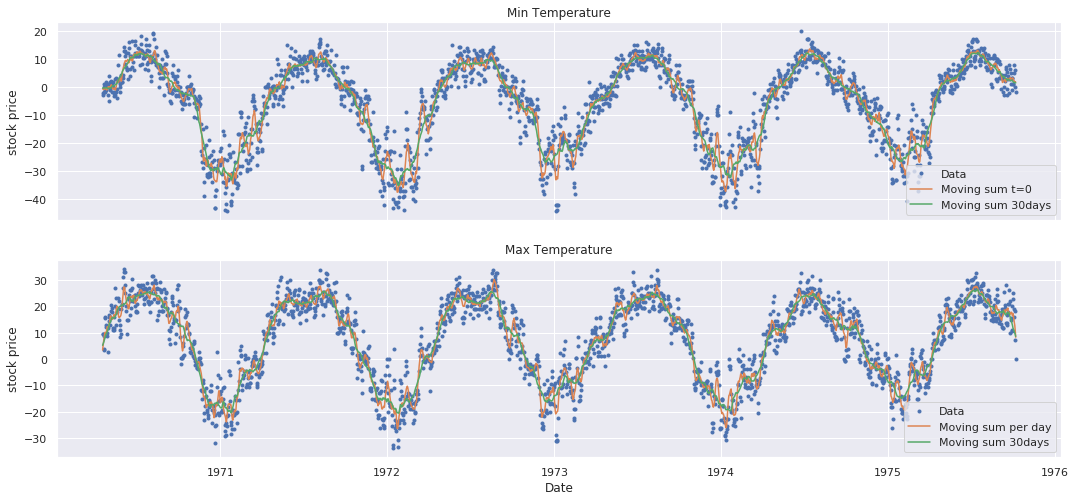

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,  figsize=(18,8))

ax1.plot(Prince_Albert_tmin[10000:12000]['date'],Prince_Albert_tmin[10000:12000]['value'], '.')
plot_smoothed(Prince_Albert_tmin[10000:12000], ax1)
plot_smoothed(Prince_Albert_tmin[10000:12000], ax1,30)
ax1.set( ylabel='stock price', title ='Min Temperature')
ax1.legend(['Data', 'Moving sum t=0', 'Moving sum 30days'])

ax2.plot(Prince_Albert_tmax[10000:12000]['date'],Prince_Albert_tmax[10000:12000]['value'], '.')

plot_smoothed(Prince_Albert_tmax[10000:12000], ax2)
plot_smoothed(Prince_Albert_tmax[10000:12000], ax2, 30)
ax2.set(xlabel='Date', ylabel='stock price', title ='Max Temperature')
ax2.legend(['Data', 'Moving sum per day', 'Moving sum 30days'])

plt.show()

Rolling window operations are another important transformation for time series data. Similar to downsampling, rolling windows split the data into time windows and and the data in each window is aggregated with a function such as mean(). The data above shows somme monthly variations. Below lets check the variation in a year.

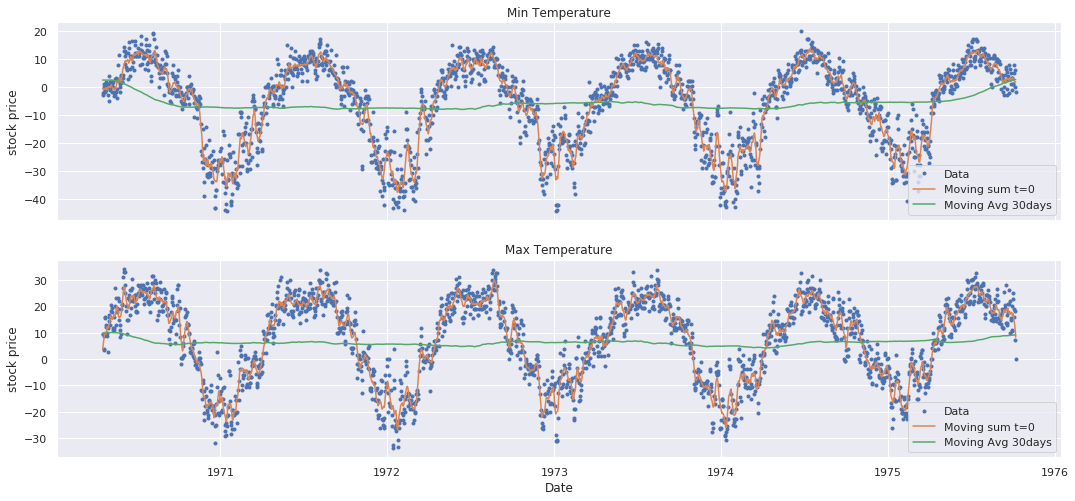

In [24]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,  figsize=(18,8))

ax1.plot(Prince_Albert_tmin[10000:12000]['date'],Prince_Albert_tmin[10000:12000]['value'], '.')
plot_smoothed(Prince_Albert_tmin[10000:12000], ax1)
plot_smoothed(Prince_Albert_tmin[10000:12000], ax1,365)
ax1.set( ylabel='stock price', title ='Min Temperature')
ax1.legend(['Data', 'Moving sum t=0', 'Moving Avg 30days'])

ax2.plot(Prince_Albert_tmax[10000:12000]['date'],Prince_Albert_tmax[10000:12000]['value'], '.')

plot_smoothed(Prince_Albert_tmax[10000:12000], ax2)
plot_smoothed(Prince_Albert_tmax[10000:12000], ax2, 365)
ax2.set(xlabel='Date', ylabel='stock price', title ='Max Temperature')
ax2.legend(['Data', 'Moving sum t=0', 'Moving Avg 30days'])

plt.show()

We can see that the mean is aproximaly constant, but there are variations that are vsibly periodic. The moving sum is performed over a day and over a year. The equation of this time series is of the form $TS(t)=A(t)\cos (wt)+b$. This follow the general form of a periodic function expressed as $f(t+T) = f(t)$, where $T$ is the period.

### b. Seasonal effects 
There seems to be a seasonal dependence on temperature, which is expected. We can further visualize this using boxplot
We want to compare maximum and minimum temperatures for specific years with the overall lowest and highes temperatures on record. This is a way to visualize the seasonal effect. 

In [25]:
def selectyear(data, year):
    '''
    Record for a psrticular year
    '''
    start = np.datetime64('{}'.format(year))
    end = start + np.timedelta64(1,'Y')    
    return data[(data['date'] >= start) & (data['date'] < end)]['value']

The data for Prince Albert for a period of 73 (from 1945 to 2018) years is given below. The seasonal effect can be observed in daily as well as in quarterly fashion.

In [26]:
Prince_Albert_tmax_all = np.vstack([selectyear(Prince_Albert_tmax,year)[:365] for year in range(1945,2018+1)])
Prince_Albert_tmin_all = np.vstack([selectyear(Prince_Albert_tmin,year)[:365] for year in range(1945,2018+1)])

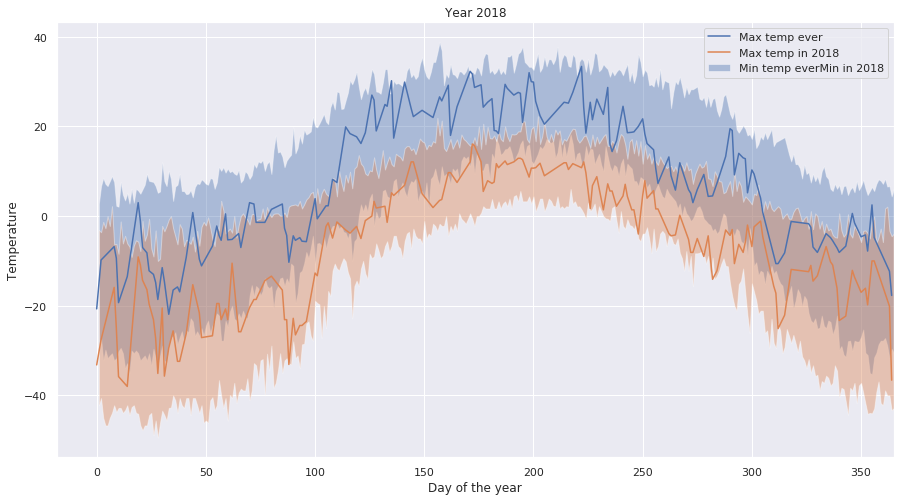

In [27]:
fig, ax = plt.subplots(figsize=(15,8))

days = np.arange(1,365+1)
ax.fill_between(days, np.min(Prince_Albert_tmax_all,axis=0),np.max(Prince_Albert_tmax_all,axis=0),alpha=0.4)
ax.plot(selectyear(Prince_Albert_tmax, 2018))

ax.fill_between(days,np.min(Prince_Albert_tmin_all,axis=0),np.max(Prince_Albert_tmin_all,axis=0),alpha=0.4)
ax.plot(selectyear(Prince_Albert_tmin, 2018))


ax.set(xlabel='Day of the year', ylabel='Temperature', title ='Year 2018')
ax.legend(['Max temp ever', 'Max temp in 2018', 'Min temp ever' 'Min in 2018'])
ax.axis(xmax=365)
plt.show()


The plot of the maximum and minimum temperature for each day, as well as the overall maximum and minimum, clearly follows the same pattern. This is a simple indication of seasonal effect in temperatures. Clearly, it also shows that higher temperatures are expected in the summer and lower temperatures are present in February. 

In [28]:
dtype = [('Q1', float), ('Q2', float), ('Q3', float), ('Q4', float)]

In [29]:
Prince_Albert_1993 = selectyear(Prince_Albert_tmax, 1993)[:365]

In [30]:
def getQuaterly(year):
    '''
    Takes a year and return a quaterly dict.
    '''
    #q = ['Q1', 'Q2', 'Q3', 'Q4']
    quaterly_date = []
    for i in range(4):
        quaterly_date.append(selectyear(Prince_Albert_tmax, year)[:365][i*91 : (i+1)*91]) #append((q[i], Prince_Albert_1993[i*91 : (i+1)*91]))
                             
    return  quaterly_date #dict(quaterly_date),

In [31]:
#Get data for a couple of years
four_decade = [1983, 1993, 2003, 2013]
four_decade_temperatures = [getQuaterly(year) for year in four_decade]

A box plot displays both central tendency and dispersion within the seasonal data over a batch of time units. Below we used to illustrate seasonal effects by use of a quarterl temperature report.

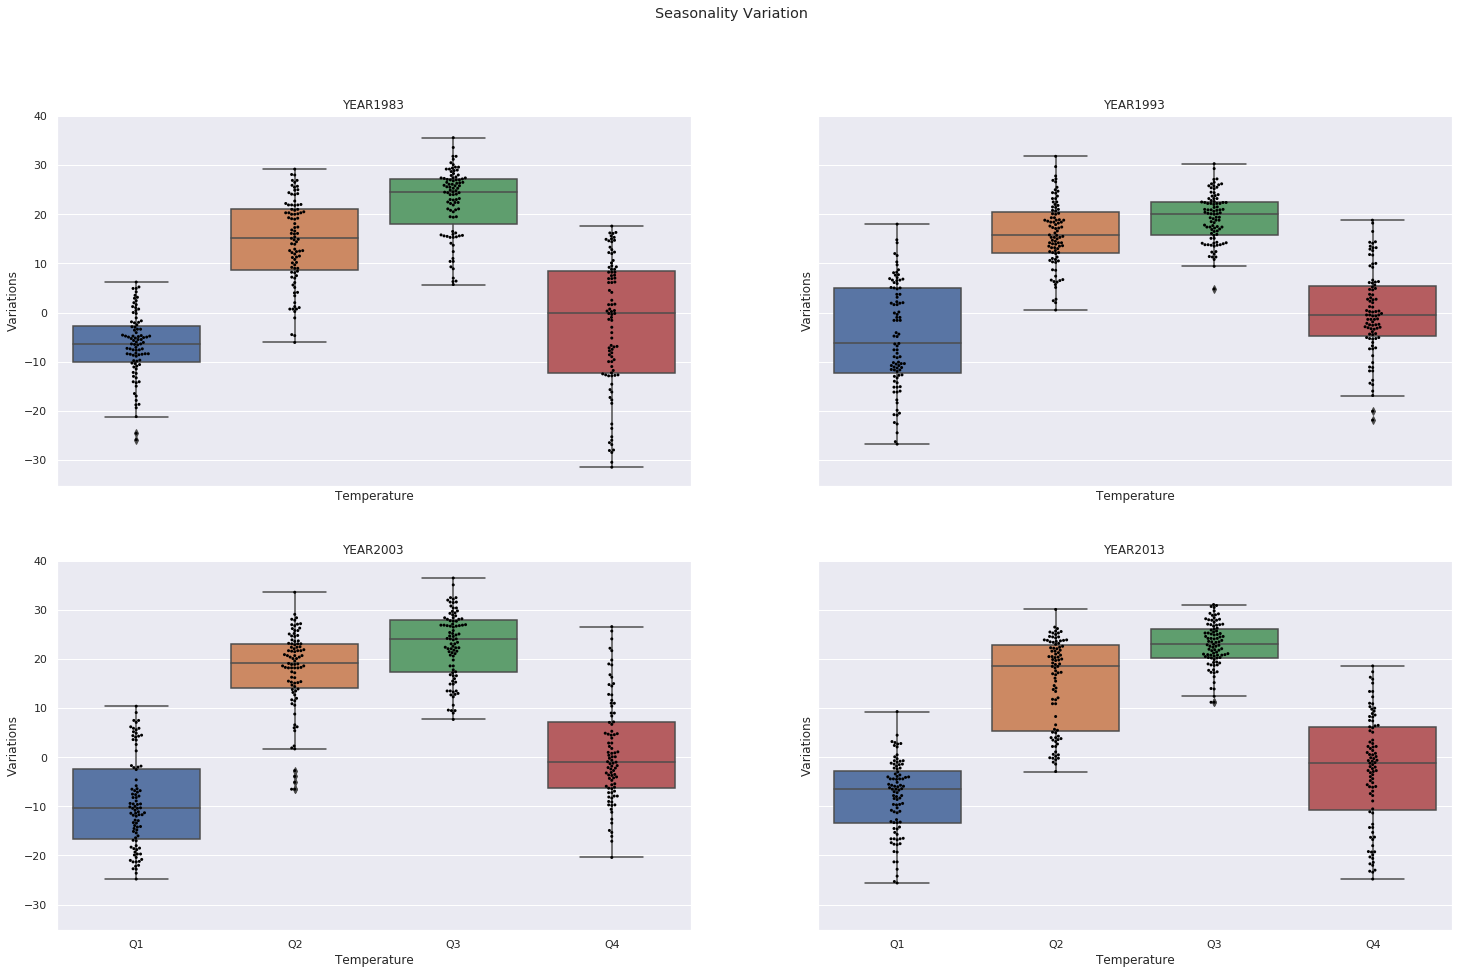

In [32]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (25,15))
#fig.subplots_adjust(hspace=0.5)
fig.suptitle('Seasonality Variation')

for ax, year, temp in zip(axes.flatten(), four_decade, four_decade_temperatures):
    sns.boxplot(data = temp, ax=ax)
    sns.swarmplot(data = temp, ax=ax, size=3, color='black')
    ax.set(title='Year'.upper()+ str(year),
       xlabel='Temperature', ylabel='Variations', xticklabels= ['Q1', 'Q2', 'Q3', 'Q4'])
plt.show()

Another way to test for the stationarity of a time series is to plot the autocorrelation function (ACF). For a nonstationary time series the ACF will not decay quickly, whereas for a stationary time series the ACF decays exponentially to 0 as lag increases. The plot of ACF below shows  an exponential decay as well as the region of conficence. The time series is stationary and so we don't need to perform any techniques that are  used to ensure stationarity.

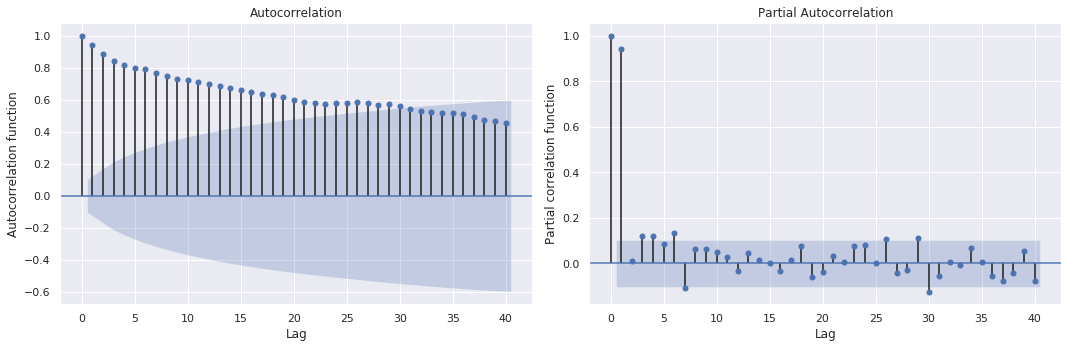

In [33]:
PA_data_list = []
PA_data_list.extend( l for l in Prince_Albert_tmax_all[0])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    # Plot ACF
plot_acf(PA_data_list, lags = 40, ax = ax1)
ax1.set(xlabel='Lag', ylabel='Autocorrelation function')

plot_pacf(PA_data_list, lags = 40, ax = ax2)
ax2.set(xlabel='Lag', ylabel='Partial correlation function')
plt.tight_layout()
plt.show()

In [34]:
Prince_Albert_extreme = {"Minimum Temperature": Prince_Albert_tmin['value'].min(), 
                         "Maximum Temperature": Prince_Albert_tmax['value'].max()}
Prince_Albert_date = {"Minimum Temperature": Prince_Albert_tmin['date'][np.argmax(Prince_Albert_tmin['value'])],
                      "Maximum Temperature": Prince_Albert_tmax['date'][np.argmax(Prince_Albert_tmax['value'])]}

In [35]:
print('Minimum temperature: ', Prince_Albert_extreme["Minimum Temperature"])
print('Maximum temperature: ', Prince_Albert_extreme["Maximum Temperature"])

Minimum temperature:  -50.0
Maximum temperature:  38.8
